In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [55]:
# Load data
training_data = pd.read_csv("/content/sample_data/train.csv")
test_data = pd.read_csv("/content/sample_data/test.csv")

In [56]:
# Handle missing data for categorical and numerical columns
categorical_columns = training_data.select_dtypes(include='object')
numerical_attributes = training_data.select_dtypes(exclude='object').drop(['SalePrice', 'Id'], axis=1).copy()

for column in ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']:
    numerical_attributes[column].fillna(numerical_attributes[column].mean(), inplace=True)

columns_to_delete_categorical = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']
categorical_columns = categorical_columns.drop(columns_to_delete_categorical, axis=1)
categorical_columns = categorical_columns.fillna('None')

cc = training_data.select_dtypes(include='object')
cc.isna().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
GarageType         81
GarageCond         81
GarageQual         81
GarageFinish       81
BsmtFinType2       38
BsmtExposure       38
BsmtFinType1       37
BsmtQual           37
BsmtCond           37
MasVnrType          8
Electrical          1
Functional          0
KitchenQual         0
CentralAir          0
HeatingQC           0
Heating             0
PavedDrive          0
SaleType            0
MSZoning            0
Street              0
Condition2          0
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
BldgType            0
Foundation          0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
ExterQual           0
ExterCond           0
SaleCondition       0
dtype: int64

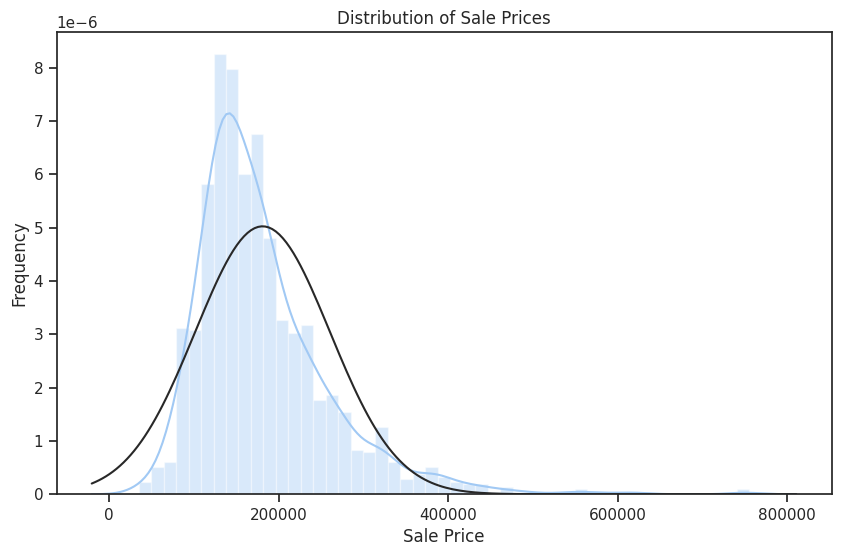

In [57]:
# Visualization 1: Distribution of Sale Prices
plt.figure(figsize=(10, 6))
sns.distplot(training_data['SalePrice'], fit=norm)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

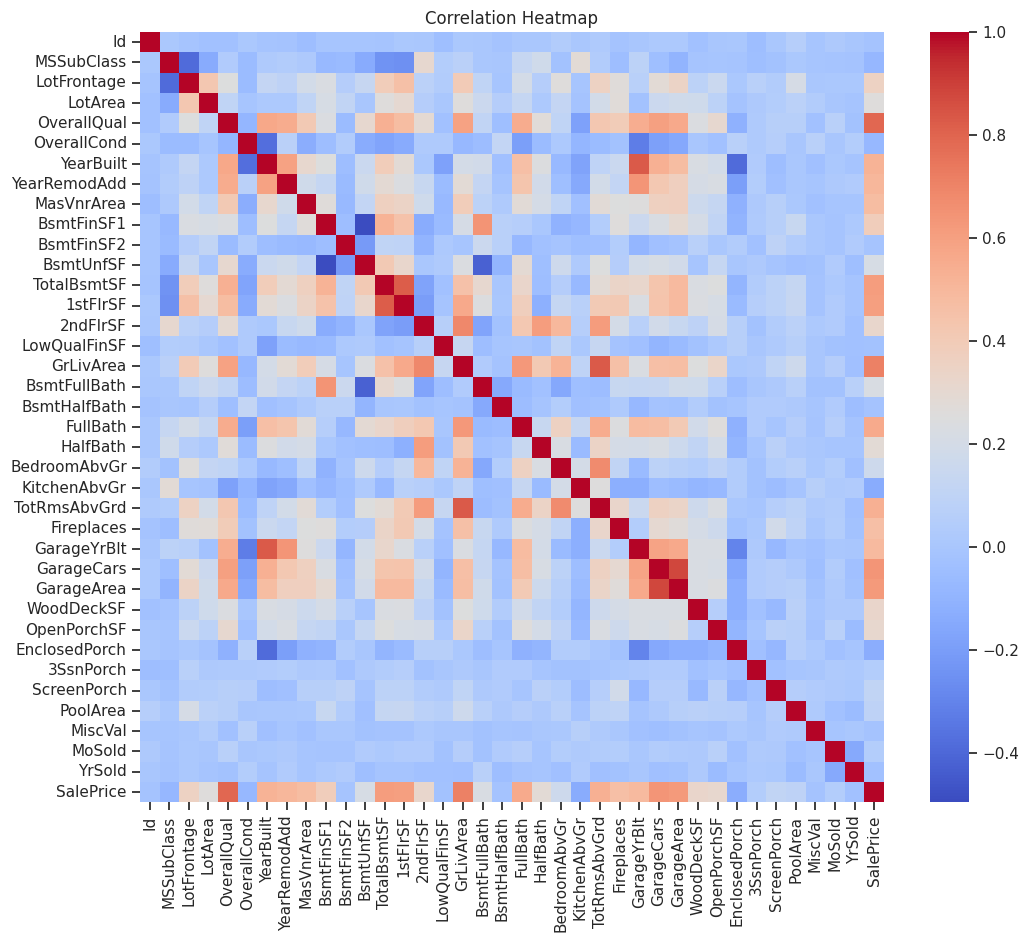

In [58]:
# Visualization 2: Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(training_data.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

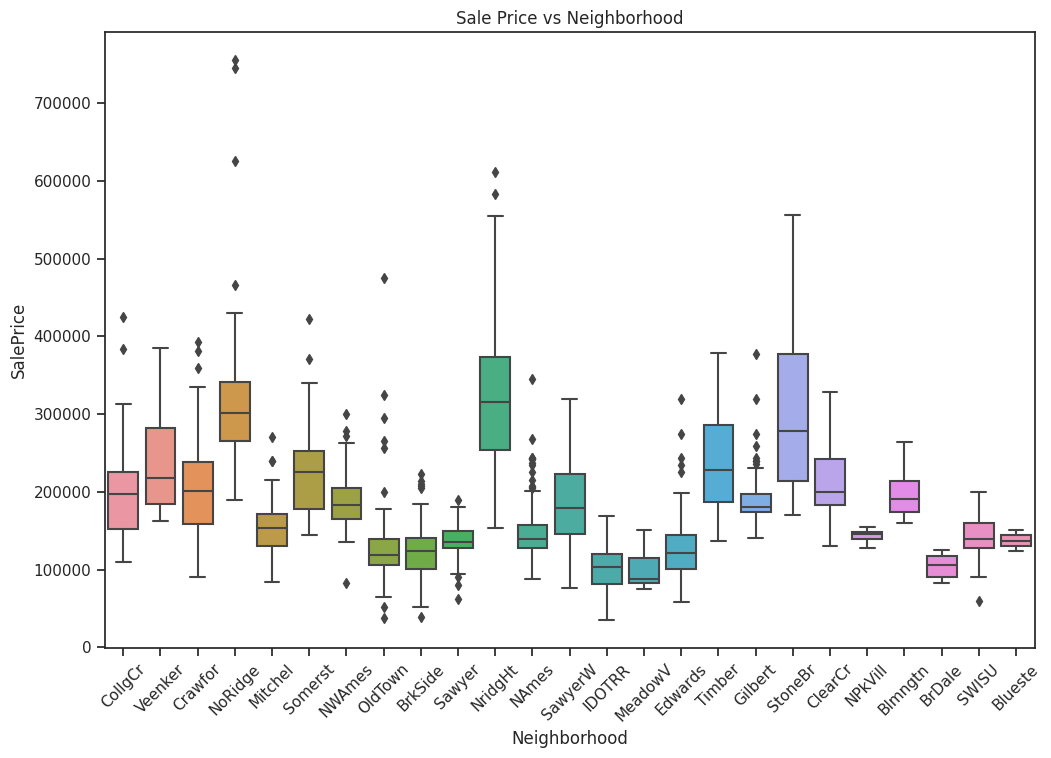

In [59]:
# Visualization 3: Box Plots for Categorical Variables vs Sale Price
plt.figure(figsize=(12, 8))
sns.boxplot(x='Neighborhood', y='SalePrice', data=training_data)
plt.xticks(rotation=45)
plt.title('Sale Price vs Neighborhood')
plt.show()

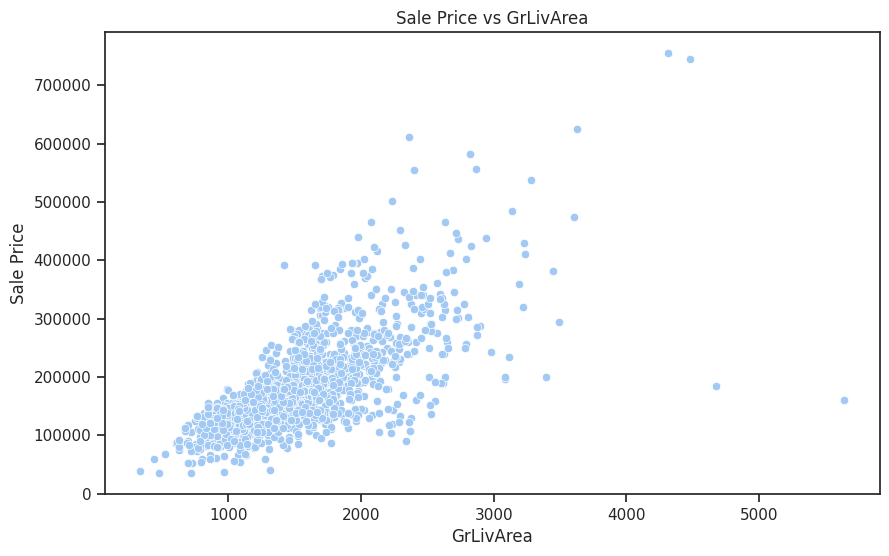

In [60]:
# Visualization 4: Scatter Plots for Important Numerical Variables vs Sale Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=training_data['GrLivArea'], y=training_data['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('Sale Price')
plt.title('Sale Price vs GrLivArea')

plt.show()


In [61]:
# Advanced Feature Engineering: Creating an interaction term
training_data['GrLivArea_TotalBsmtSF'] = training_data['GrLivArea'] * training_data['TotalBsmtSF']

# Log Transformation of the Target Variable
training_data['SalePrice'] = np.log(training_data['SalePrice'])


In [62]:
# Prepare the final data frame
final_data_frame = pd.concat([categorical_columns, numerical_attributes, training_data[['GrLivArea_TotalBsmtSF', 'SalePrice']]], axis=1)
final_data_frame_encoded = pd.get_dummies(final_data_frame)

# Splitting data into training and validation sets
features = final_data_frame_encoded.drop(['SalePrice'], axis=1)
target = final_data_frame_encoded['SalePrice']
train_features, val_features, train_target, val_target = train_test_split(features, target, test_size=0.2, random_state=1)


In [63]:
# Model training with RandomForestRegressor
rf_model = RandomForestRegressor(random_state=1)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(train_features, train_target)

# Evaluate the model
val_predictions = grid_search.predict(val_features)
mae_val = mean_absolute_error(val_target, val_predictions)
print("Validation Mean Absolute Error:", mae_val)

Validation Mean Absolute Error: 0.09625614620733751


In [64]:
# Test data preprocessing
test_data_clean = test_data.drop(columns_to_delete_categorical + ['Id'], axis=1)
test_data_clean_numeric = test_data_clean.select_dtypes(exclude=['object'])
test_data_clean_category = test_data_clean.select_dtypes(include=['object'])
test_data_clean_numeric = test_data_clean_numeric.fillna(0)
test_data_clean_category = test_data_clean_category.fillna("None")

In [65]:
# Creating an interaction term in test data
test_data_clean['GrLivArea_TotalBsmtSF'] = test_data_clean['GrLivArea'] * test_data_clean['TotalBsmtSF']

# Preparing final test data
test_data_final = pd.concat([test_data_clean_category, test_data_clean_numeric, test_data_clean[['GrLivArea_TotalBsmtSF']]], axis=1)
test_data_final_encoded = pd.get_dummies(test_data_final)


In [66]:
# Aligning and predicting on test data
final_train_data, final_test_data = features.align(test_data_final_encoded, join='left', axis=1)
final_test_data.fillna(0, inplace=True)

# Predictions on test data
predictions_test = np.exp(grid_search.predict(final_test_data))  # Inverse log transformation

print("Predictions for the first 5 houses in the test data:")
print(predictions_test[:5])

Predictions for the first 5 houses in the test data:
[127926.77858781 156914.81449743 174756.7394119  182790.15818175
 192052.88427038]


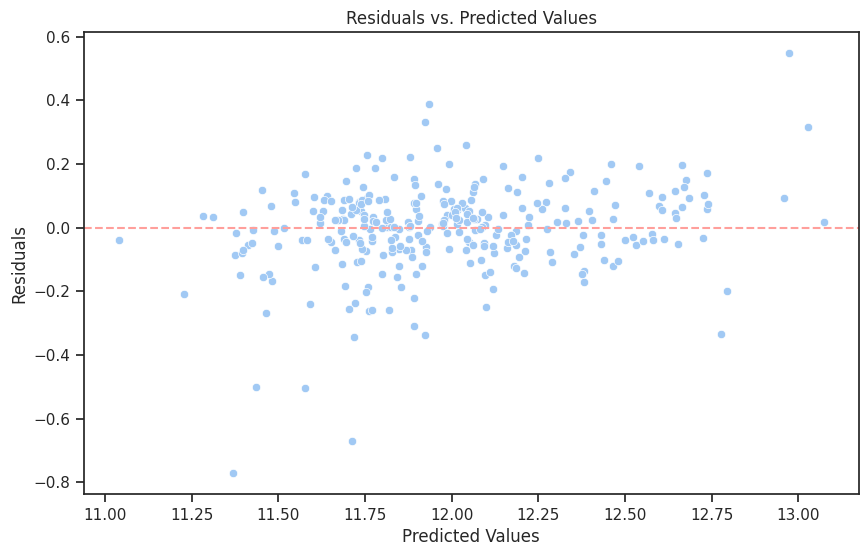

In [67]:
# Residual Plot
residuals = val_target - val_predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=val_predictions, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()


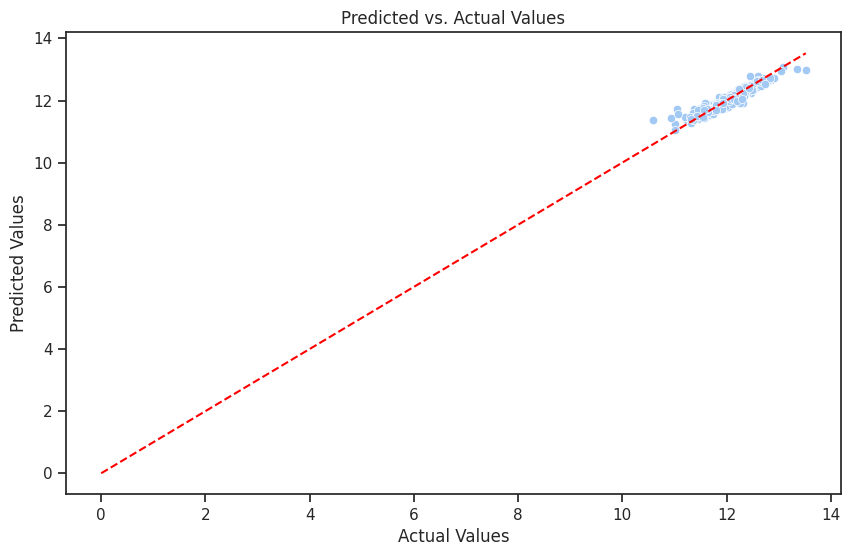

In [68]:
# Prediction vs. Actual Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=val_target, y=val_predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
# Plotting the identity line
max_val = max(val_target.max(), val_predictions.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')
plt.show()